In [82]:
from io import BytesIO
import requests

import cv2
import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image
import pandas as pd

In [83]:
import json
from ast import literal_eval

Explain and evaluate how we get the nicer borders

# load image for sample

In [84]:
sample = pd.read_csv('./data/identifiers.csv', header=None)
doc = sample.iloc[1, 1]
url = doc+'/f1.highres.jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img = np.array(img)

# Example of functions used to extract 

In [85]:
def contourOK(img, cc):
    """Check if the contour is a good predictor of photo location."""
    if near_edge(img, cc): return False # shouldn't be near edges
    x, y, w, h = cv2.boundingRect(cc)
    if w < 100 or h < 100: return False # too narrow or wide is bad
    area = cv2.contourArea(cc)
    if area < (get_size(img) * 0.3): return False
    return True

def near_edge(img, contour):
    """Check if a contour is near the edge in the given image."""
    x, y, w, h = cv2.boundingRect(contour)
    ih, iw = img.shape[:2]
    mm = 50 # margin in pixels
    return (x < mm
            or x + w > iw - mm
            or y < mm
            or y + h > ih - mm)

def white_percent(img):
    """Return the percentage of the thresholded image that's white."""
    w,h = img.shape
    newimg = np.where(img == 255, 1, 0)
    return sum(sum(newimg)) / (w*h)

In [86]:
img2 = img.astype(np.float)

We check that either one of the two conditions is met.

In [87]:
cond1 = (img2[:, :, 2] - img2[:, :, 0]) > -15
cond2 = (img2[:, :, 1] - img2[:, :, 0]) > -15

Then we check which one covers the image better. See plots below to get an intuition

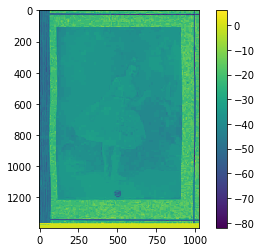

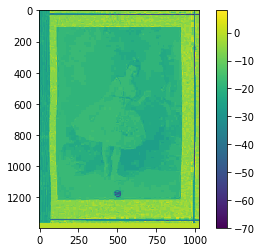

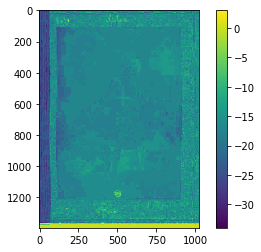

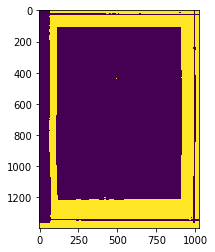

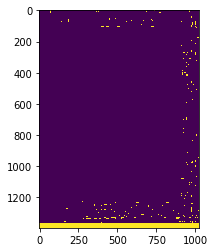

In [88]:
plt.imshow((img2[:, :, 2] - img2[:, :, 0]))
plt.colorbar()
plt.show()

plt.imshow((img2[:, :, 1] - img2[:, :, 0]))
plt.colorbar()
plt.show()

plt.imshow((img2[:, :, 2] - img2[:, :, 1]))
plt.colorbar()
plt.show()

plt.imshow(cond2)
plt.show()
plt.imshow(cond1)
plt.show()

In [89]:
src = np.where(cond1[:, :, None].repeat(3, axis=2), np.full_like(img, 255), img).astype(np.uint8)

In [106]:
gray = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
imgray = gray
tl = 250
ret, thresh = cv2.threshold(imgray, tl, 255, 0)

while white_percent(thresh) > 0.85:
    tl += 10
    ret, thresh = cv2.threshold(imgray, tl, 255, 0)

contours, hierarchy, _ = cv2.findContours(thresh, 1, 2)

plt.imshow(cv2.drawContours(img, contours, -1, (0,255,0), 3))
plt.show()
contours = [cc for cc in contours if contourOK(imgray, cc)]

error: OpenCV(3.4.7) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/drawing.cpp:2511: error: (-215:Assertion failed) npoints > 0 in function 'drawContours'


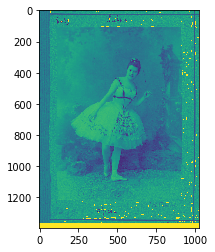

In [91]:
plt.imshow(gray)

# evaluate heuristic

## transform image, check for blue border

-> R or G are less dominant, check whatever gives better results

give margin of 15, but is found empirically

In [92]:
# average color in that block

if False:
    sample = pd.read_csv('identifiers.csv', header=None)

    def get_image(doc):
        url = doc+'/f1.highres.jpg'
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))

        img = Image.open(BytesIO(response.content)).convert('RGB')
        img = np.array(img)
        return img


    def image_median(img):
        return np.median(np.median(img, axis=1), axis=0)

    colors = []

    for doc in sample[1].sample(2):
        img = get_image(doc)
        h, w, d = img.shape

        #mid left of image
        avg_1 = img[int(w/2): int(w/2)+10, :10, :]
        avg_1 = image_median(avg_1)

        #mid right of image
        avg_2 = img[int(w/2): int(w/2)+10, -10:, :]
        avg_2 = image_median(avg_2)

        #mid top of image

        avg_3 = img[: 10, int(h/2):int(h/2)+10, :]
        avg_3 = image_median(avg_3)

        avg_color = np.median(np.median(img[0:10, 0:10, :], axis=1), axis=0)
        colors.append({'avg1': avg_1, 'avg2': avg_2, 'avg3': avg_3})
    #    np.save('colors.npy', colors)

In [93]:
with open('../scripts/colors.json') as f:
    d = json.load(f)

In [94]:
colors = pd.DataFrame(d)

In [95]:
def check_blue(x):
    return ((x[2] - x[0])) > -15 or ((x[1] - x[0])) > -15

is_blue = colors.apply(lambda x: check_blue(x.avg1) or check_blue(x.avg2) or check_blue(x.avg3), axis=1)

We check for blue of green by checking the dominace of the B and G values. Is true for most! except some washed out images .. we handle them by being more generous

In [96]:
is_blue.value_counts()

True     10320
False        2
dtype: int64

In [97]:
def check_blue(x):
    return ((x[2] - x[0])) > -10 or ((x[1] - x[0])) > -18

is_blue = colors.apply(lambda x: check_blue(x.avg1) or check_blue(x.avg2) or check_blue(x.avg3), axis=1)
is_blue.value_counts()

True    10322
dtype: int64

### Visualizing the side color:

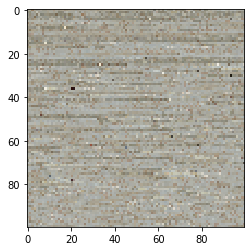

In [104]:
colors_ = colors.avg3.map(lambda x: np.asarray(x).astype(np.uint8)).tolist()
colors_ = np.array(colors_)

grouping = np.array(colors_[:10000]).reshape((100, -1, 3))
plt.imshow(grouping)

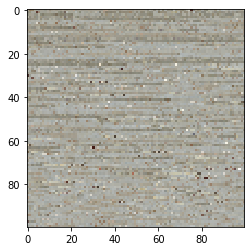

In [103]:
colors_ = colors.avg1.map(lambda x: np.asarray(x).astype(np.uint8)).tolist()
colors_ = np.array(colors_)

grouping = np.array(colors_[:10000]).reshape((100, -1, 3))
plt.imshow(grouping)

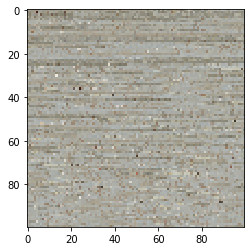

In [105]:
colors_ = colors.avg2.map(lambda x: np.asarray(x).astype(np.uint8)).tolist()
colors_ = np.array(colors_)

grouping = np.array(colors_[:10000]).reshape((100, -1, 3))
plt.imshow(grouping)